# The Response of Sea Surface Temperature to Rain

Newly revised notebook of code 6/22/22

In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as datetime
import glob
import scipy
import tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import matplotlib.dates as mdates
#%matplotlib inline
import gsw
import metpy
from subprocess import Popen, PIPE
from time import sleep
import os
from dateutil import parser

import matlab.engine

#from scipy.signal import find_peaks
from scipy.io import loadmat

### 1. Data Import

This shows how all the importing was done - skip to step 2 in order to start right away with final data structures that are aready within this repository.

In [2]:
# import R/V Revelle data 
revelle_datapath = '../Data/Level_3/Dynamo/Revelle_FluxData/Revelle_All_Legs_r4.cdf'
rv = xr.open_dataset(revelle_datapath)

# import MJO phase & add to Revelle dataset
mjo = pd.read_csv('../Data/Level_0/MJO phase/rmm.74toRealtime.txt', sep='\s+',skiprows=2,parse_dates=[[0,1,2]],index_col=0,
                   names=['year','month','day','RMM1','RMM2','phase','amplitude'],usecols=[0,1,2,3,4,5,6]).loc[slice(rv.index[0].values,rv.index[-1].values)]
rv['mjo_phase'] = mjo.phase.to_xarray().rename({'year_month_day':'index'}).interp_like(rv,method='nearest')

#import COARE rain heat flux output as a dictionary of numpy arrays using the scipy loadmat function
SHFr_Leg1 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg1_r4.mat')
SHFr_Leg2 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg2_r4.mat')
SHFr_Leg3 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg3_r4.mat')
SHFr_Leg4 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_rainAdjusted_Leg4_r4.mat')
SHFr = np.concatenate((SHFr_Leg1['SHF_rain'][0,:],SHFr_Leg2['SHF_rain'][0,:],SHFr_Leg3['SHF_rain'][0,:],SHFr_Leg4['SHF_rain'][0,:]))

SSTr_Leg1 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg1_r4.mat')
SSTr_Leg2 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg2_r4.mat')
SSTr_Leg3 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg3_r4.mat')
SSTr_Leg4 = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjusted_Leg4_r4.mat')
SSTr = np.concatenate((SSTr_Leg1['SSTB'][0,:],SSTr_Leg2['SSTB'][0,:],SSTr_Leg3['SSTB'][0,:],SSTr_Leg4['SSTB'][0,:]))

SSTr_bulk = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_rainAdjustedFROMBULK_ALLLEGS.mat')['SST'][0,:]
SST_bulk = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SST_baseCOARE_FROMBULK_ALLLEGS.mat')['SST'][0,:]

SHF_fromBulk = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_baseCOARE_fromBulk_AllLegs.mat')['shf'][0,:]
SHF_fromSkin = loadmat('../Data/Level_1/Dynamo/Revelle_FluxData/SHF_baseCOARE_fromKT15_AllLegs.mat')['shfC'][0,:]

rv = rv.assign({'SSTrain': xr.DataArray(SSTr,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SSTrain_fromBulk': xr.DataArray(SSTr_bulk,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SST_fromBulk': xr.DataArray(SST_bulk,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SHFrain': xr.DataArray(SHFr,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SHF_fromBulk': xr.DataArray(SHF_fromBulk,dims='index',coords={'index':rv.index})})
rv = rv.assign({'SHF_fromSkin': xr.DataArray(SHF_fromSkin,dims='index',coords={'index':rv.index})})

# import DC fluxes and add to Revelle dataset
#load file as a dictionary of numpy arrays using the scipy loadmat function
Edson_raw = loadmat('../Data/Level_1/Dynamo/DC Fluxes From Edson (with closed path)/Transfer_D05.mat')
#drop the metadata keys from the dictionary so that all the remaining arrays are the same size
del Edson_raw['__header__']
del Edson_raw['__version__']
del Edson_raw['__globals__']
del Edson_raw['D']
del Edson_raw['zi']
del Edson_raw['zq']
del Edson_raw['zt']
del Edson_raw['zu']
del Edson_raw['cpa']
del Edson_raw['lstatchk']
del Edson_raw['uklMeas']
del Edson_raw['uklsave']
year = 2011
date = datetime.datetime(year, 1, 1) + pd.to_timedelta(Edson_raw['yday'][0]-1,unit='days')
Edson_Fluxes = pd.DataFrame(index=date)
#iterate over each key in the dict and add to the pandas dataframe as a new column
for key in Edson_raw:
    #print(key)
    Edson_Fluxes[key] = Edson_raw[key][0].tolist()
Edson_Fluxes = Edson_Fluxes.to_xarray()

#interpolate coare outputs onto DC timestamps
Edson_Fluxes['Hl_bulk'] = rv.lhf.interp_like(Edson_Fluxes,method='linear')

#calculate closed-path sensible heat flux
ρ = Edson_Fluxes.rhoair #[kg/m^3]
LE = 2260               #[kJ/kg]
q = Edson_Fluxes.Qair   #[g/kg]
T = Edson_Fluxes.Tair + 273.15   #[C] -> [K]
wTs = Edson_Fluxes.WTr  #[m/s K]

#calculate w'q' from COARE Latent Heat Flux output
wq = Edson_Fluxes.Hl_bulk/ρ/LE/1000

#calculate Sensible Heat Flux
wT = (wTs - 0.518*T*wq) / (1 + 0.518*(q/1000))   # ( [m/s K] - [K][m/s][g/g] ) / [g/g] ) -> [m/s][K]
cp = 1.005 + 1.82*(q/1000) #[J/g K]
HsC = ρ*cp*wT*1000 
Edson_Fluxes['HsC'] = HsC

rv['HsC'] = Edson_Fluxes.HsC.interp_like(rv,method='linear')
#rv

In [3]:
#import SST data
kt_dynamo = xr.open_dataset('../Data/Level_3/Dynamo/KT15_WarmCal/Dynamo_KT15_CalibratedSST_v2.cdf')
#sort dataset into sequential timesteps
kt_dynamo = kt_dynamo.sortby(kt_dynamo.index)
#resample SST to 10 second mean
kt_10s = kt_dynamo.SST.resample(index='10s').mean()

In [4]:
#add KT-15 to rv dataset and compute gradient variables Tskin-Tair and Qsat(Tskin)-Qair
rv['sst_skin'] = kt_10s.rolling(index=6).mean().interp_like(rv,method='linear')
rv['ΔT_skin_air'] = rv.sst_skin - rv.T02

T = rv.sst_skin #C
P = rv.Pair10 #mbar

saturation_vapor_pressure = 6.112*np.exp(17.67*T/(T+243.5)) #Bolton [1980] for T in C, yields pressure in hPa aka mbar
saturation_mixing_ratio = 0.622*saturation_vapor_pressure/(P - saturation_vapor_pressure) #Hobbs [1977], unitless
qsat = saturation_mixing_ratio / (1 + saturation_mixing_ratio) * 1000 #g/g -> g/kg

rv['qsat_tskin'] = qsat
rv['Δq_skin_air'] = rv.qsat_tskin - rv.Q02

In [25]:
rv.to_netcdf('./final_data_structure_1min.nc')
kt_10s.to_netcdf('./final_data_structure_10s_radiometry.nc')

### 2. Event Detection

See supplementary material for sensitivity analysis to the detection parameters.

In [ ]:
#import data if needed
rv = xr.open_dataset('./final_data_structure_1min.nc')
kt_10s = xr.open_dataset('./final_data_structure_10s_radiometry.nc')

In [6]:
#how many minutes before rain onset do we want to average as the baseline from which to calculate a delta?
pre_onset_averaging = 3

In [7]:
from RainEvent_Toolbox import find_rain_events
rain_event_list = find_rain_events(dataset = rv, 
                                   min_duration = 10,
                                   min_separation = 30,
                                   threshold = 5,
                                   noise_floor = 0.5,
                                   front_pad = 5,
                                   end_pad = 5)
#plt.savefig('./Figures/Dynamo Rain Event Detection v4.png')

In [8]:
len(rain_event_list)

72

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


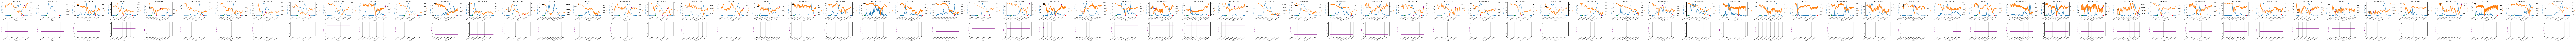

In [9]:
from RainEvent_Toolbox import sst_rain_response
sst_event_list = sst_rain_response(rain_event_list = rain_event_list,
                                   sst = kt_10s,
                                   pre_onset_averaging = pre_onset_averaging)

Based on careful inspection, we're going to exclude rain events where either we are missing SST measurements or they appear to be contaminated by a signal that is present in SST and not in the Sea Snake that does not correspond to any trends in other physical variables measured.

In [10]:
exclude = [i-1 for i in [2, 38, 48]]
exclude

[1, 37, 47]

In [11]:
resub = [event for num,event in enumerate(rain_event_list) if num not in exclude]
sstsub = [event for num,event in enumerate(sst_event_list) if num not in exclude]

rain_event_list = resub
sst_event_list = sstsub

In [12]:
len(rain_event_list)

69

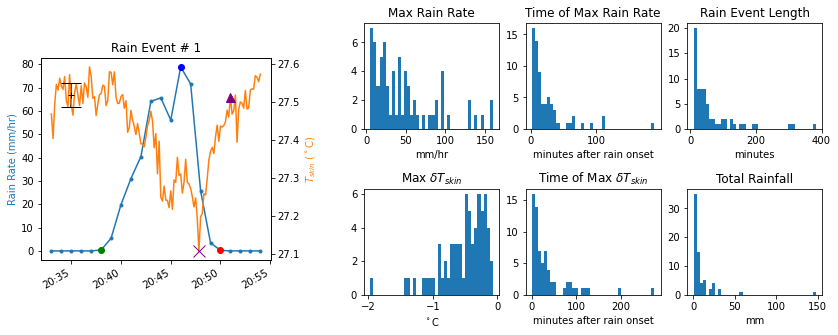

In [13]:
# plot summary of detected events
from RainEvent_Toolbox import extract_event_characteristics, plot_histograms
rain_events_summary = extract_event_characteristics(rain_event_list, sst_event_list)

#new plot that combines an example event with the histograms
fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot2grid(shape=(8,20),loc=(1,0),rowspan=6,colspan=6)

#----example event--
event_num = 0
start = pd.to_datetime(rain_event_list[event_num].attrs['Rain Onset'])
end = pd.to_datetime(rain_event_list[event_num].attrs['Rain End'])
first = rain_event_list[event_num].index[0]
last = rain_event_list[event_num].index[-1]
#plot precipitation rate
rain_event_list[event_num].P.plot.line('-o',ax=ax1,markersize=3,fillstyle=None)
ax1.set_ylabel('Rain Rate (mm/hr)',color='C0')
ax1.set_xlabel('')

#plot rainfall start and end times
ax1.plot(start,rain_event_list[event_num].P.sel(index=start),'.g',markersize=12,fillstyle=None)
ax1.plot(end,rain_event_list[event_num].P.sel(index=end),'.r',markersize=12,fillstyle=None)
#plot rainfall peak
ax1.plot(rain_event_list[event_num].attrs['Peak Time'],rain_event_list[event_num].attrs['Peak Rate'],'.b',markersize=12,fillstyle=None)

#plot SST
ax2 = ax1.twinx()
sst_event_list[event_num].sst.plot.line('C1',ax=ax2,fillstyle=None)
ax2.set_ylabel('$T_{skin}$ ($^\circ$C)',color='C1')
#plot max δSST and pre-onset mean + std
try:
    ax2.plot(sst_event_list[event_num].attrs['Time of max δsst'],sst_event_list[event_num].sst.sel(index=sst_event_list[event_num].attrs['Time of max δsst']),'x',color='darkmagenta',markersize=12)
    ax2.errorbar(sst_event_list[event_num].attrs['pre-onset time'],sst_event_list[event_num].attrs['pre-onset mean'],yerr=sst_event_list[event_num].attrs['pre-onset std'],fmt='+k',ecolor='k',capsize=10)
except KeyError:
    None

try:
    ax2.plot(sst_event_list[event_num].attrs['Time of sst recovery'],sst_event_list[event_num].sst.sel(index=sst_event_list[event_num].attrs['Time of sst recovery']),'^',color='purple',markersize=9)
except KeyError:
    None

#title
ax1.set_title(f'Rain Event # {event_num+1}')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#----histograms----
nbins=40
ax3 = plt.subplot2grid(shape=(10,5),loc=(0,2),rowspan=4,colspan=1)
ax4 = plt.subplot2grid(shape=(10,5),loc=(0,3),rowspan=4,colspan=1)
ax5 = plt.subplot2grid(shape=(10,5),loc=(0,4),rowspan=4,colspan=1)
ax6 = plt.subplot2grid(shape=(10,5),loc=(6,2),rowspan=4,colspan=1)
ax7 = plt.subplot2grid(shape=(10,5),loc=(6,3),rowspan=4,colspan=1)
ax8 = plt.subplot2grid(shape=(10,5),loc=(6,4),rowspan=4,colspan=1)

rain_events_summary.rain_max.plot.hist(ax=ax3,bins=nbins);
ax3.set_title('Max Rain Rate')
ax3.set_xlabel('mm/hr')

rain_events_summary.t_rain_max.plot.hist(ax=ax4,bins=nbins);
ax4.set_title('Time of Max Rain Rate')
ax4.set_xlabel('minutes after rain onset')

rain_events_summary.L_rain.plot.hist(ax=ax5,bins=nbins);
ax5.set_title('Rain Event Length')
ax5.set_xlabel('minutes')

rain_events_summary.δsst_max.plot.hist(ax=ax6,bins=nbins);
ax6.set_title('Max $δT_{skin}$')
ax6.set_xlabel('$^\circ$C')

rain_events_summary.t_δsst_max.plot.hist(ax=ax7,bins=nbins);
ax7.set_title('Time of Max $δT_{skin}$')
ax7.set_xlabel('minutes after rain onset')

rain_events_summary.rain_total.plot.hist(ax=ax8,bins=nbins)
ax8.set_title('Total Rainfall')
ax8.set_xlabel('mm');

#plt.tight_layout()
#plt.subplots_adjust(wspace=0.2)
#plt.savefig('./Figures/Example Event + Histograms v4.png',dpi=300)


### 3. SST Modeling

In [15]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 5 #[m] depth of ship intake

# run modified (& regular) Bellenger model for each rain event and add the outputs to the rain_event_list
for event_num in np.arange(0,len(rain_event_list)):

    #------------SET UP MODEL INPUT-----------------
    event = rain_event_list[event_num]
    
    U = event.Ur10.values
    T_fnd = event.TseaTSG.values
    T_air = event.T10.values
    q = event.Q10.values/1000 # unit conversion g/kg -> kg/kg
    rsds = -event.Solardn.values
    p = event.Pair10.values
    rain = event.P.values
    shf = event.shf.values 
    lhf = event.lhf.values 
    rln = event.IRdn.values + event.IRup.values #net IR, positive upwards
    tau = event.stress.values
    s1 = event.SalTSG.values
    #initialize time as number of elapsed seconds from first timestep
    time = (event.index - event.index[0]).values.astype(float) * 10**-9

    #---------------RUN MODEL WITH VOLUME FRACTION ON-------------------
    model_vF = pd.DataFrame(index=event.index.values)
    [t_int_vF, s_int_vF, tkt_vF, tks_vF, dter_vF, dser_vF, dt_ns_vF, ds_ns_vF, rf_vF, taur_vF] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=True, spread_flag=True)
    
    #---------------RUN MODEL WITH VOLUME FRACTION OFF------------------
    model = pd.DataFrame(index=event.index.values)
    [t_int, s_int, tkt, tks, dter, dser, dt_ns, ds_ns, rf, taur] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=False, spread_flag=False)

    #---------------ASSIGN OUTPUT PARAMETERS TO RAIN EVENT--------------
    rain_event_list[event_num]['t_int_vF'] = ('index', t_int_vF)
    rain_event_list[event_num]['s_int_vF'] = ('index', s_int_vF)
    rain_event_list[event_num]['tkt_vF'] = ('index', tkt_vF)
    rain_event_list[event_num]['tks_vF'] = ('index', tks_vF)
    rain_event_list[event_num]['dter_vF'] = ('index', dter_vF)
    rain_event_list[event_num]['dser_vF'] = ('index', dser_vF)
    rain_event_list[event_num]['dt_ns_vF'] = ('index', dt_ns_vF)
    rain_event_list[event_num]['ds_ns_vF'] = ('index', ds_ns_vF)
    rain_event_list[event_num]['rf_vF'] = ('index', rf_vF)
    rain_event_list[event_num]['taur_vF'] = ('index', taur_vF)
    
    rain_event_list[event_num]['t_int'] = ('index', t_int)
    rain_event_list[event_num]['s_int'] = ('index', s_int)
    rain_event_list[event_num]['tkt'] = ('index', tkt)
    rain_event_list[event_num]['tks'] = ('index', tks)
    rain_event_list[event_num]['dter'] = ('index', dter)
    rain_event_list[event_num]['dser'] = ('index', dser)
    rain_event_list[event_num]['dt_ns'] = ('index', dt_ns)
    rain_event_list[event_num]['ds_ns'] = ('index', ds_ns)
    rain_event_list[event_num]['rf'] = ('index', rf)
    rain_event_list[event_num]['taur'] = ('index', taur)

100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1352.98it/s]


## Step 3 again but feeding the Model with Sea Snake

In [16]:
%autoreload
from Ocean_Skin_Model import ocean_skin

TSG_depth = 0.05 #[m] depth of sea snake now -  try 10cm instead of 5 for consistency with previous studies?

# run modified (& regular) Bellenger model for each rain event and add the outputs to the rain_event_list
for event_num in np.arange(0,len(rain_event_list)):

    #------------SET UP MODEL INPUT-----------------
    event = rain_event_list[event_num]
    
    U = event.Ur10.values
    T_fnd = event.Tsea.values
    T_air = event.T10.values
    q = event.Q10.values/1000 # unit conversion g/kg -> kg/kg
    rsds = -event.Solardn.values
    p = event.Pair10.values
    rain = event.P.values
    shf = event.shf.values 
    lhf = event.lhf.values 
    rln = event.IRdn.values + event.IRup.values #net IR, positive upwards
    tau = event.stress.values
    s1 = event.SalTSG.values
    #initialize time as number of elapsed seconds from first timestep
    time = (event.index - event.index[0]).values.astype(float) * 10**-9

    #---------------RUN MODEL WITH VOLUME FRACTION ON-------------------
    model_vF = pd.DataFrame(index=event.index.values)
    [t_int_vF, s_int_vF, tkt_vF, tks_vF, dter_vF, dser_vF, dt_ns_vF, ds_ns_vF, rf_vF, taur_vF] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=True, spread_flag=True)
    
    #---------------RUN MODEL WITH VOLUME FRACTION OFF------------------
    model = pd.DataFrame(index=event.index.values)
    [t_int, s_int, tkt, tks, dter, dser, dt_ns, ds_ns, rf, taur] = ocean_skin(time, U, T_fnd, s1, T_air, q, rsds, p, rain, shf, lhf, rln, tau, depth_1=TSG_depth, jcool=True, jwarm=True, rain_effect=True, fV_flag=False, spread_flag=True)

    #---------------ASSIGN OUTPUT PARAMETERS TO RAIN EVENT--------------
    rain_event_list[event_num]['t_int_vF_SS'] = ('index', t_int_vF)
    rain_event_list[event_num]['s_int_vF_SS'] = ('index', s_int_vF)
    rain_event_list[event_num]['tkt_vF_SS'] = ('index', tkt_vF)
    rain_event_list[event_num]['tks_vF_SS'] = ('index', tks_vF)
    rain_event_list[event_num]['dter_vF_SS'] = ('index', dter_vF)
    rain_event_list[event_num]['dser_vF_SS'] = ('index', dser_vF)
    rain_event_list[event_num]['dt_ns_vF_SS'] = ('index', dt_ns_vF)
    rain_event_list[event_num]['ds_ns_vF_SS'] = ('index', ds_ns_vF)
    rain_event_list[event_num]['rf_vF_SS'] = ('index', rf_vF)
    rain_event_list[event_num]['taur_vF_SS'] = ('index', taur_vF)
    
    rain_event_list[event_num]['t_int_SS'] = ('index', t_int)
    rain_event_list[event_num]['s_int_SS'] = ('index', s_int)
    rain_event_list[event_num]['tkt_SS'] = ('index', tkt)
    rain_event_list[event_num]['tks_SS'] = ('index', tks)
    rain_event_list[event_num]['dter_SS'] = ('index', dter)
    rain_event_list[event_num]['dser_SS'] = ('index', dser)
    rain_event_list[event_num]['dt_ns_SS'] = ('index', dt_ns)
    rain_event_list[event_num]['ds_ns_SS'] = ('index', ds_ns)
    rain_event_list[event_num]['rf_SS'] = ('index', rf)
    rain_event_list[event_num]['taur_SS'] = ('index', taur)

100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1210.25it/s]


### 4. Composite Rain Event

First we want to calculate the deltas for any variables we might be interested in from the rain events ($\delta$SST was already calculated):

In [17]:
#because the extract_composite_event function is looking for a variable of the form δ{"name"}, we're fudging HsC by naming it with a delta in front when we first add it to the dataset. Kind of clunky but it works.
param_list = ['Tsea','TseaTSG','SalTSG','T02','T10','U10','Precip','rhf','SST','HsC','lhf','shf','Q02','wspd','t_int','t_int_vF','s_int','s_int_vF','t_int_SS','t_int_vF_SS','s_int_SS','s_int_vF_SS','SHF_fromBulk','SHF_fromSkin','Δq_skin_air','ΔT_skin_air']

In [18]:
from RainEvent_Toolbox import calculate_deltas
rain_event_list = calculate_deltas(rain_event_list = rain_event_list,
                                   param_list = param_list,
                                   pre_onset_averaging = pre_onset_averaging)

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Now we're ready to put together a composite plot of these delta variables for all rain events. The key is to normalize the timescale by the time to peak SST response, i.e. 
$$ Normalized Time = \frac{(CurrentMinute - StartMinute)}{(Minutes to Max \delta SST)} $$

This way, the rain start is at zero and the peak SST response is at 1. This allows us to superimpose all the rain events in a meaningful way. I've also scaled the size of the dots to indicate what proportion of events were involved in each bin (all events are included between timesteps 0 and 1, of course).

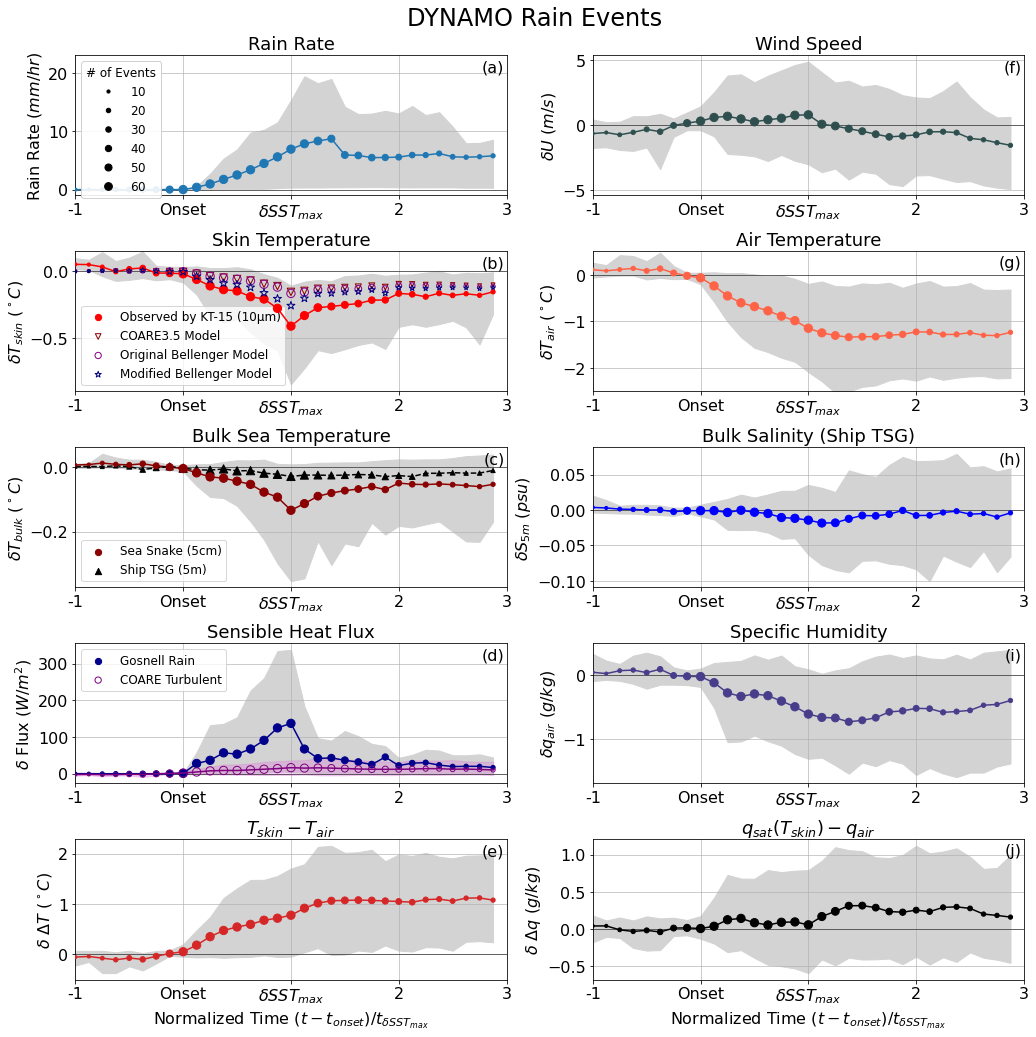

In [19]:
plt.rcParams['font.size'] = 12
%autoreload
from RainEvent_Toolbox import extract_composite_event_10panel
composite_event = extract_composite_event_10panel(rain_event_list = rain_event_list, 
                                          sst_event_list = sst_event_list, 
                                          param_list = param_list, 
                                          start = -1, 
                                          stop = 3, 
                                          spacing = 1/8,
                                          plotflag = 1,
                                          title = 'DYNAMO Rain Events')
#plt.savefig('./Figures/Composite Events REVISED v5.png', dpi=300)

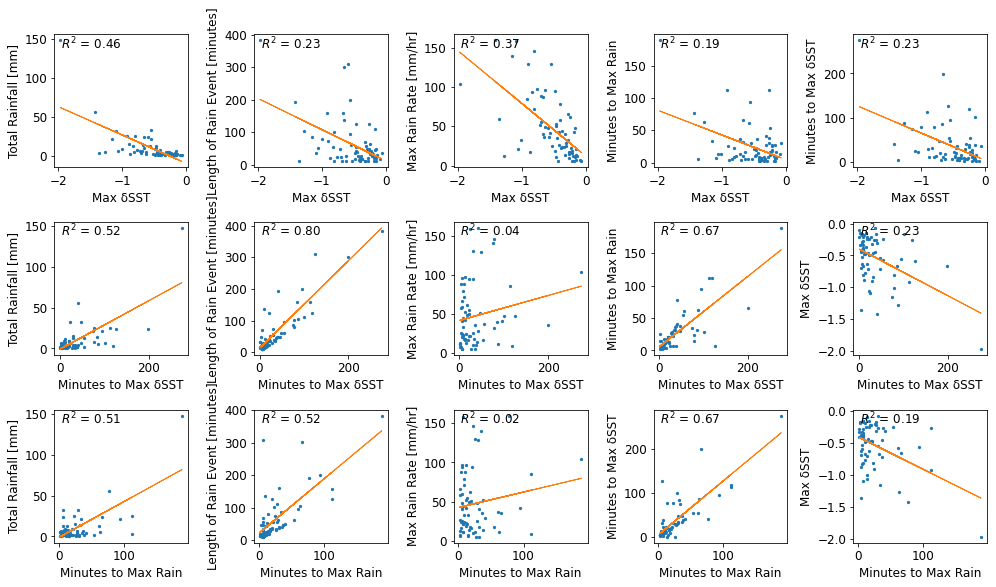

In [20]:
%autoreload
from RainEvent_Toolbox import plot_relationships
plot_relationships(rain_events_summary)
#plt.savefig('./Figures/Scatterplots v3.png')

The highest correlations are between:
- Minutes to Max $\delta$SST vs. Length of Rain Event ($R^2$ = 0.80)
- Minutes to Max $\delta$SST vs. Minutes to Max Rain ($R^2$ = 0.67)

## 5. Plotting Skin Temp Observations vs Models

In [21]:
def diff_plot(observed, modeled, color, axis, cmap, marker, size):
    observed  = np.asarray(observed)
    modeled   = np.asarray(modeled)
    diff      = modeled - observed                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 2*sd
    CI_high   = md + 2*sd

    axis.scatter(observed, diff, c=color, s=size, cmap=cmap, marker=marker)
    axis.axhline(md,           color='black', linestyle='-')
    axis.axhline(md + 2*sd, color='gray', linestyle='--')
    axis.axhline(md - 2*sd, color='gray', linestyle='--')
    xtext = np.nanmax(observed)#*1.001
    axis.text(x=xtext+0.15,y=md-0.04,s='Mean')
    axis.text(x=xtext+0.15,y=md-0.04 + 2*sd, s='+2σ', color='gray')
    axis.text(x=xtext+0.15,y=md-0.04 - 2*sd, s='-2σ', color='gray')
    axis.text(x=xtext+0.1,y=1.3, s=f'{md.round(3)} $\pm$ {sd.round(3)}', ha='right')


In [22]:
num_list = []
time_list = []
sst_list = []
t_int_list = []
t_int_vF_list = []
t_int_SS_list = []
t_int_vF_SS_list = []
sst_raincoare_list = []
sst_raincoare_SS_list = []
sst_coare_list = []
sst_coare_SS_list = []
sw_list =[]
p_list = []


for event_num in np.arange(len(rain_event_list)):
    if event_num not in exclude:
        event = rain_event_list[event_num]
        #resample to 1min and fill in any missing gaps
        sst = sst_event_list[event_num].sst.resample(index='1min').mean().interp_like(event)
        sst = sst.where(np.isfinite(sst),drop=True).where(event.P > 0.5, drop=True)
        event = event.where(np.isfinite(sst),drop=True).where(event.P >0.5, drop=True)

        num_list.append(event_num*np.ones_like(sst.values))
        time_list.append(event.index.values)
        sst_list.append(sst.values)
        t_int_list.append(event.t_int.values)
        t_int_vF_list.append(event.t_int_vF.values)
        t_int_SS_list.append(event.t_int_SS.values)
        t_int_vF_SS_list.append(event.t_int_vF_SS.values)

        p_list.append(event.P.values)
        sw_list.append(event.Solardn.values)

        sst_raincoare_list.append(event.SSTrain_fromBulk.values)
        sst_raincoare_SS_list.append(event.SSTrain.values)
        sst_coare_list.append(event.SST_fromBulk.values)
        sst_coare_SS_list.append(event.SST.values)
    
event_nums = np.concatenate(num_list)
time = np.concatenate(time_list)
sst = np.concatenate(sst_list)
t_int = np.concatenate(t_int_list)
t_int_vF = np.concatenate(t_int_vF_list)
t_int_SS = np.concatenate(t_int_SS_list)
t_int_vF_SS = np.concatenate(t_int_vF_SS_list)
sst_raincoare = np.concatenate(sst_raincoare_list)
sst_raincoare_SS = np.concatenate(sst_raincoare_SS_list)
sst_coare = np.concatenate(sst_coare_list)
sst_coare_SS = np.concatenate(sst_coare_SS_list)
sw = np.concatenate(sw_list)
p = np.concatenate(p_list)

In [23]:
def get_r2_linear(x, y):
    '''Only works for linear fits'''
    return np.corrcoef(x, y)[0, 1]**2

def diff_plot_2(observed, modeled, xvalues, color, axis, cmap, marker, size):
    observed  = np.asarray(observed)
    modeled   = np.asarray(modeled)
    diff      = modeled - observed                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 2*sd
    CI_high   = md + 2*sd

    axis.scatter(xvalues, diff, c=color, s=size, cmap=cmap, marker=marker,zorder=1)
    axis.axhline(md,           color='dimgrey', linestyle='-',zorder=0)
    axis.axhline(md + 2*sd, color='darkgray', linestyle='--',zorder=0)
    axis.axhline(md - 2*sd, color='darkgray', linestyle='--',zorder=0)
    
    #xthresh=np.max(xvalues) #only fit to values below this threshold
    #inds = [i for i in range(len(xvalues)) if xvalues[i] < xthresh] #indices where the xvalue is below threshold
    diffsub = diff#[inds]  #[y if x<thresh for x, y, thresh in zip(xvalues, diff, xthresh)]
    xsub = xvalues#[inds] 
    
    coef = np.polyfit(xsub,diffsub,1)
    poly1d_fn = np.poly1d(coef) # poly1d_fn is now a function which takes in x and returns an estimate for y
    axis.plot(xvalues, poly1d_fn(xvalues), ':k') #'--k'=black dashed line, 'yo' = yellow circle marker
    
    r2 = get_r2_linear(xsub,diffsub)
    
    xtext = np.nanmax(xvalues)#*1.001
    axis.text(x=xtext+2,y=md-0.04,s='Mean',color='dimgrey')
    axis.text(x=xtext+2,y=md-0.04 + 2*sd, s='+2σ', color='darkgray')
    axis.text(x=xtext+2,y=md-0.04 - 2*sd, s='-2σ', color='darkgray')
    axis.text(x=xtext-1,y=1.3, s=f'Mean = {md.round(3)} $\pm$ {2*sd.round(3)}', ha='right')
    axis.text(x=xtext-1,y=1, s=f'y = {coef[0].round(4)}x + {coef[1].round(3)}', ha='right')
    axis.text(x=xtext-1,y=0.7, s=f'$R^2$ = {r2.round(3)}', ha='right')


Text(0.06, 0.2, 'Temperature\nInput: 5m\nShip TSG')

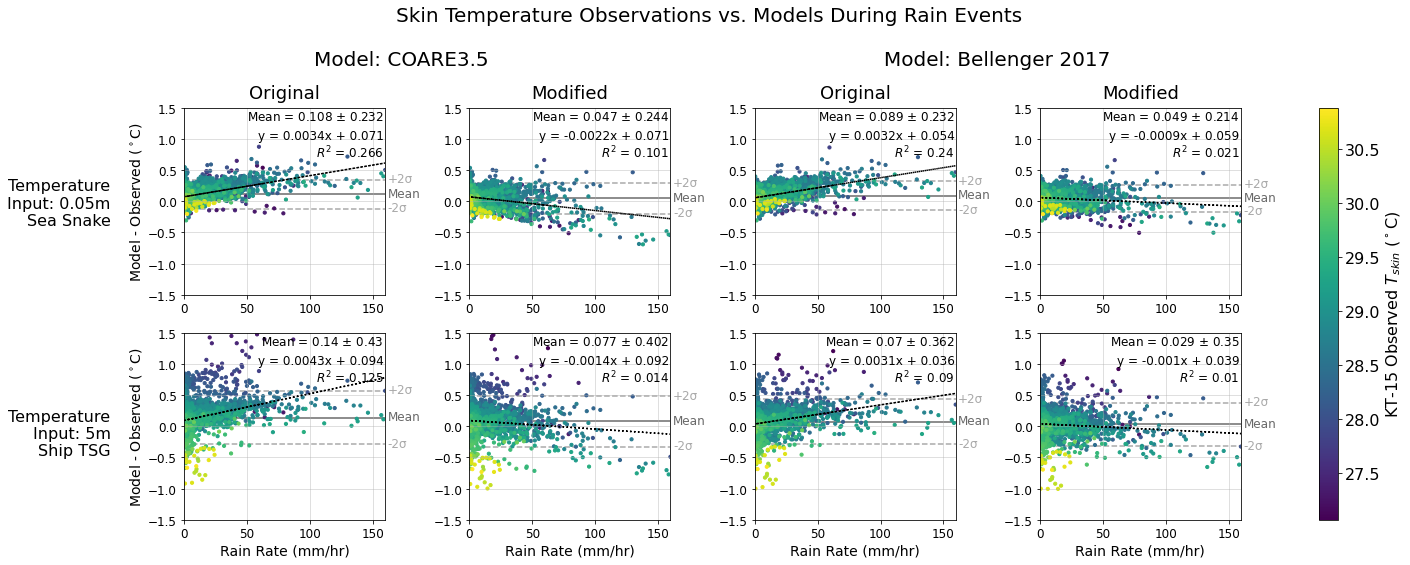

In [24]:
#make version of this figure that is 2 rows (SS or TSG) and 4 columns (ModBel, OrigBel, ModCOARE, OrigCOARE) with RAIN RATE ON X-AXIS
ftsz = 14

fig = plt.figure(figsize=(19,8))

axx00 = plt.subplot2grid(shape=(2,10),loc=(0,1),rowspan=1,colspan=2)
axx01 = plt.subplot2grid(shape=(2,10),loc=(0,3),rowspan=1,colspan=2)
axx02 = plt.subplot2grid(shape=(2,10),loc=(0,5),rowspan=1,colspan=2)
axx03 = plt.subplot2grid(shape=(2,10),loc=(0,7),rowspan=1,colspan=2)
axx10 = plt.subplot2grid(shape=(2,10),loc=(1,1),rowspan=1,colspan=2)
axx11 = plt.subplot2grid(shape=(2,10),loc=(1,3),rowspan=1,colspan=2)
axx12 = plt.subplot2grid(shape=(2,10),loc=(1,5),rowspan=1,colspan=2)
axx13 = plt.subplot2grid(shape=(2,10),loc=(1,7),rowspan=1,colspan=2)

cmap = mpl.cm.viridis
marker = 'o'
size = 10

#sort the plotting order by precip amount so that we see all the high-precip values on top in the scatterplots
order = np.argsort(sst)

diff_plot_2(sst[order], t_int_SS[order], p[order], sst[order], axis=axx03, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], t_int_vF_SS[order], p[order], sst[order], axis=axx02, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_raincoare_SS[order], p[order], sst[order], axis=axx01, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_coare_SS[order], p[order], sst[order], axis=axx00, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], t_int[order], p[order], sst[order], axis=axx13, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], t_int_vF[order], p[order], sst[order], axis=axx12, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_raincoare[order], p[order], sst[order], axis=axx11, cmap=cmap, marker=marker, size=size)
diff_plot_2(sst[order], sst_coare[order], p[order], sst[order], axis=axx10, cmap=cmap, marker=marker, size=size)


pad=10
axx03.set_title('Modified', pad=pad,fontdict={'size':ftsz+4})
axx02.set_title('Original', pad=pad,fontdict={'size':ftsz+4})
axx01.set_title('Modified', pad=pad,fontdict={'size':ftsz+4})
axx00.set_title('Original', pad=pad,fontdict={'size':ftsz+4})

plt.suptitle('Skin Temperature Observations vs. Models During Rain Events \n \nModel: COARE3.5                                                              Model: Bellenger 2017',fontsize=20)#,y=0.95)
    
axx00.set_ylabel('Model - Observed ($^\circ$C)',fontdict={'size':ftsz})
axx10.set_ylabel('Model - Observed ($^\circ$C)',fontdict={'size':ftsz})

for axis in [axx10,axx11,axx12,axx13]:
    axis.set_xlabel('Rain Rate (mm/hr)',fontdict={'size':ftsz})

for axis in [axx00,axx01,axx02,axx03,axx10,axx11,axx12,axx13]:
    axis.grid(alpha=0.5)
    axis.set_ylim([-1.5,1.5])
    axis.set_xlim([0,p.max()])

        
plt.tight_layout()

axxcb = plt.subplot2grid(shape=(2,30),loc=(0,28),rowspan=2,colspan=1)

norm = mpl.colors.Normalize(vmin = sst.min(), vmax=sst.max())
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axxcb)
cbar.ax.tick_params(labelsize=ftsz+2)
cbar.set_label(label='KT-15 Observed $T_{skin}$ ($^\circ$C)', fontsize=ftsz+2)


plt.text(x=0.06,y=0.6,s='Temperature\nInput: 0.05m\nSea Snake', transform=fig.transFigure,fontdict={'size':ftsz+2},ha='right')
plt.text(x=0.06,y=0.2,s='Temperature\nInput: 5m\nShip TSG', transform=fig.transFigure,fontdict={'size':ftsz+2},ha='right')


#plt.savefig('./Figures/Observed vs. Modeled SST rain data v10.png',bbox_inches='tight', dpi=300)

## 5.5 Plotting $fV(z)$ for different rain rates

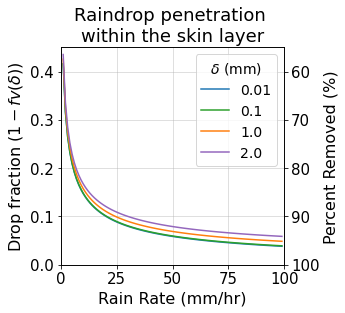

In [11]:
from Ocean_Skin_Model import fV

rains = np.arange(1,100)
Ps = rains / 3600. # convert mm/h -> kg m-2 s-1
zs = [0.00001, 0.0001, 0.001, 0.002]
cs = ['C0','C2','C1','C4']
handles = []

fig,axx = plt.subplots(figsize=(4,4))
for z,c in zip(zs,cs):
    fVs = []
    for rain in Ps:
        fVs.append(1-fV(z,rain))
    h = axx.plot(rains,fVs,color=c)
    handles.append(h)
    
lz = [z*1000 for z in zs]
axx.legend(labels=lz,title='$\delta$ (mm)',fontsize=14,title_fontsize=14)
axx.grid(alpha=0.5)
axx.set_xlim([0,100])
axx.set_ylim([0,0.45])
axx.set_xlabel('Rain Rate (mm/hr)',fontsize=16)
axx.tick_params(labelsize=15)
axx.set_ylabel('Drop fraction ($1-fv(\delta)$)',fontsize=16)
axx.set_title('Raindrop penetration \nwithin the skin layer',fontsize=18)

par = axx.twinx()
par.set_ylim([0,0.45])
par.set_yticks([0.0,0.1,0.2,0.3,0.4])
par.set_yticklabels(['100','90','80','70','60'])
par.tick_params(labelsize=15)
par.set_ylabel('Percent Removed (%)',fontsize=16)

plt.savefig('./Figures/fV plot v2.png',dpi=300,bbox_inches='tight')

## 6. Plotting difference between skin and bulk temperature and resulting SHF from COARE

In [ ]:
#calculate differential variables between skin and bulk
rv['skin_bulk_shf'] = rv.SHF_fromSkin - rv.SHF_fromBulk
rv['sst_skin'] = kt_10s.rolling(index=6).mean().interp_like(rv,method='linear') #take 1 minute rolling mean and then cast onto rv timestamps
rv['skin_bulk_sst'] = rv.sst_skin - rv.TseaTSG 

#subset rv to make the groupby_bins operation execute quickly
rv_sub = xr.merge([rv.P, rv.skin_bulk_shf, rv.skin_bulk_sst, rv.Solardn])
#split into day and night 
rv_night = rv_sub.where(rv_sub.Solardn > -15) #when theres less than 15W/m^2 of solar energy, it night. Sign convention is negative for downwelling.
rv_day = rv_sub.where(rv_sub.Solardn <= -15)

step=3
rv_gb_night = rv_night.groupby_bins('P',bins=np.arange(0,160,step))
rv_gb_day = rv_day.groupby_bins('P',bins=np.arange(0,160,step))

rv_Pmeans_night = rv_gb_night.mean()
rv_Pmeans_day = rv_gb_day.mean()

rv_std_night = rv_gb_night.std()
rv_std_day = rv_gb_day.std()

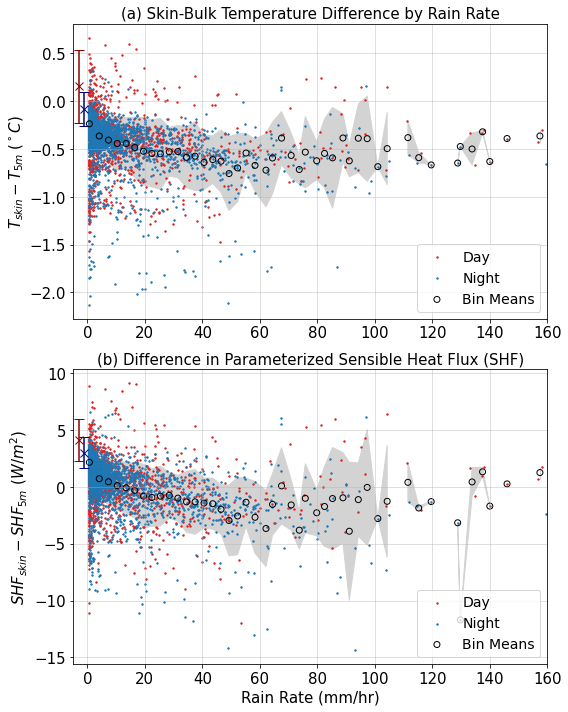

In [69]:
rv_rain_night = rv_night.where(rv_night.P>=0.5)
rv_rain_day = rv_day.where(rv_day.P>=0.5)

rv_dry_night = rv_night.where(rv.P<0.5)
rv_dry_day = rv_day.where(rv.P<0.5)

fontsz = 15

fig,axx = plt.subplots(nrows=2,figsize=(8,10))

#-------------------------------
axx[0].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_sst+rv_std.skin_bulk_sst), y2=(rv_Pmeans.skin_bulk_sst-rv_std.skin_bulk_sst), color='lightgrey')
# DAY
h1 = axx[0].scatter(rv_rain_day.P, rv_rain_day.skin_bulk_sst,s=2,c='C3')
axx[0].errorbar(-3,rv_dry_day.skin_bulk_sst.mean(), rv_dry_day.skin_bulk_sst.std(),capsize=5, marker='x',color='darkred',markersize=8)
# NIGHT
h2 = axx[0].scatter(rv_rain_night.P, rv_rain_night.skin_bulk_sst,s=2,c='C0')
axx[0].errorbar(-1,rv_dry_night.skin_bulk_sst.mean(), rv_dry_night.skin_bulk_sst.std(),capsize=5, marker='x',color='navy',markersize=8)
# TOTAL BIN MEANS
h3 = axx[0].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_sst, edgecolor='k', facecolor='None',zorder=10)
axx[0].grid(alpha=0.5)
axx[0].legend([h1,h2,h3],['Day','Night','Bin Means'],loc='lower right',fontsize=14)

#-------------------------------
axx[1].fill_between(x=rv_Pmeans.P, y1=(rv_Pmeans.skin_bulk_shf+rv_std.skin_bulk_shf), y2=(rv_Pmeans.skin_bulk_shf-rv_std.skin_bulk_shf), color='lightgrey')
# DAY
axx[1].scatter(rv_rain_day.P, rv_rain_day.skin_bulk_shf,s=2,c='C3')
axx[1].errorbar(-3,rv_dry_day.skin_bulk_shf.mean(), rv_dry_day.skin_bulk_shf.std(),capsize=5, marker='x',color='darkred',markersize=8)
# NIGHT
axx[1].scatter(rv_rain_night.P, rv_rain_night.skin_bulk_shf,s=2,c='C0')
axx[1].errorbar(-1,rv_dry_night.skin_bulk_shf.mean(), rv_dry_night.skin_bulk_shf.std(),capsize=5, marker='x',color='navy',markersize=8)
# TOTAL
axx[1].scatter(rv_Pmeans.P, rv_Pmeans.skin_bulk_shf, edgecolor='k', facecolor='None', zorder=1)
axx[1].grid(alpha=0.5)
axx[1].legend([h1,h2,h3],['Day','Night','Bin Means'],loc='lower right',fontsize=14)

#-------------------------------
axx[1].set_xlabel('Rain Rate (mm/hr)', fontsize=fontsz)
axx[1].set_ylabel('$SHF_{skin} - SHF_{5m}$ ($W/m^2$)', fontsize=fontsz)
axx[0].set_ylabel('$T_{skin} - T_{5m}$ ($^\circ C$)', fontsize=fontsz)

axx[0].set_title('(a) Skin-Bulk Temperature Difference by Rain Rate', fontsize=fontsz)
axx[1].set_title('(b) Difference in Parameterized Sensible Heat Flux (SHF)', fontsize=fontsz)

for axis in axx:
    axis.tick_params(axis='both', which='both', labelsize=fontsz)
    axis.set_xlim([-5,160])

plt.tight_layout()

plt.savefig('../Publication/JGR Submission 1/Figures/Figure_6.png',dpi=300)

## 7. Wind Effects

In [97]:
from RainEvent_Toolbox import extract_composite_event_SS

#generate plot of wind speed bin vs. max delta-sst
δsst_means = []
δsst_stds = []
δTsea_means = []
δTsea_stds = []
sizes = []
wind_bins = np.arange(2,17)

for wind_bin in tqdm.tqdm(wind_bins):
    rain_bin = []
    sst_bin = []

    #loop through each event and determine whether it belongs in this bin
    for rain,sst in zip(rain_event_list,sst_event_list):
        start = pd.to_datetime(rain.attrs['Rain Onset'])
        sst_max = pd.to_datetime(sst.attrs['Time of max δsst'])
        wind_mean = rain.U10.sel(index=slice(start,sst_max)).mean().item()

        if (wind_mean>wind_bin-0.5 and wind_mean<=wind_bin+0.5):
            rain_bin.append(rain)
            sst_bin.append(sst)

    composite_bin = extract_composite_event(rain_event_list = rain_bin, 
                                              sst_event_list = sst_bin, 
                                              param_list = param_list, 
                                              start = -2, 
                                              stop = 7, 
                                              spacing = 0.2,
                                              plotflag = 0,
                                              title = '')

    #calculate mean and std of composite event at maximum δsst
    δsst_mean_bin = composite_bin.δsst.mean(dim='event',skipna=True).sel(index=1).item()
    δsst_std_bin = composite_bin.δsst.std(dim='event',skipna=True).sel(index=1).item()
    
    δsst_means.append(δsst_mean_bin)
    δsst_stds.append(δsst_std_bin)
    
    #calculate mean and std of composite event at maximum δTsea
    δTsea_mean_bin = composite_bin.δTsea.mean(dim='event',skipna=True).sel(index=1).item()
    δTsea_std_bin = composite_bin.δTsea.std(dim='event',skipna=True).sel(index=1).item()
    
    δTsea_means.append(δTsea_mean_bin)
    δTsea_stds.append(δTsea_std_bin)
    
    #calculate how many entries are involved with each event to scale dot sizes
    entries = composite_bin.δsst.sel(index=1).count().values.item()
    
    sizes.append(entries*10)


  7%|█████▌                                                                             | 1/15 [00:00<00:08,  1.71it/s]C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.52it/s]


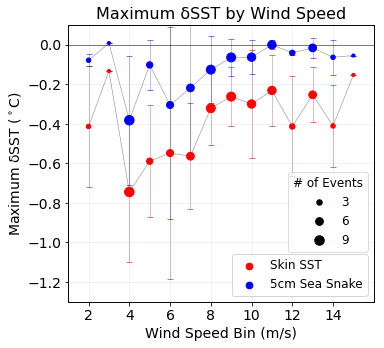

In [102]:
panel_font = 14
title_font = 16
capsz = 3

fig,axx = plt.subplots(figsize=(5.5,5))

axx.errorbar(x=wind_bins, y=δsst_means, yerr=δsst_stds, fmt='-k', ecolor='darkred', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h1 = axx.scatter(x=wind_bins, y=δsst_means, s=sizes, c='red',zorder=200)

axx.errorbar(x=wind_bins, y=δTsea_means, yerr=δTsea_stds, fmt='-k', ecolor='darkblue', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h2 = axx.scatter(x=wind_bins, y=δTsea_means, s=sizes, c='blue',zorder=200)

#axx.plot(wind_bins,np.zeros(len(wind_bins)),color='k',linewidth = 0.5,zorder=1000)
axx.hlines(y=0,xmin=0,xmax=17,color='k',linewidth = 0.5,zorder=1000)

axx.legend([h1,h2],['Skin SST','5cm Sea Snake'],loc='lower right')

par = axx.twinx()
par.legend(handles = h2.legend_elements("sizes", num=3)[0], labels=['3','6','9'], title='# of Events', bbox_to_anchor=(1,0.49), framealpha=0.7).set_zorder(1000)
par.set_yticks([])

plt.title('Maximum δSST by Wind Speed', fontsize=title_font)

axx.set_xlim([1,16])
axx.set_ylim([-1.3,0.1])

axx.set_xlabel('Wind Speed Bin (m/s)', fontsize=panel_font)
axx.set_ylabel('Maximum δSST ($^\circ$C)', fontsize=panel_font)
axx.xaxis.set_tick_params(labelsize=panel_font)
axx.yaxis.set_tick_params(labelsize=panel_font)

axx.set_xticks([2,4,6,8,10,12,14])
axx.grid(alpha=0.2)

plt.tight_layout()
#plt.savefig('./Figures/Max dSST by Wind Speed v1.png', dpi=300)

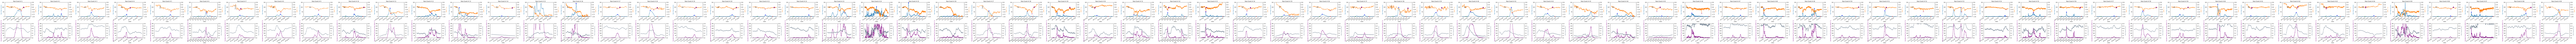

In [77]:
%autoreload
from RainEvent_Toolbox import plot_rain_events
plot_rain_events(rain_event_list = rain_event_list,  
                 sst_event_list = sst_event_list, 
                 rain_ylims = [-1,150],
                 δsst_ylims = [-1,0.5],
                 rhf_ylims = [0,300],
                 wind_ylims = [0,15])
#plt.savefig('./Figures/Dynamo Rain Events + deltaSST + Wind v3.png')

In [132]:
#hand-picking only simplest events
simple_events =  [1,2,4,5,6,8,9, 10,11,13,17,18,19,26,   27,32,33,36,40,41,42,      53,58,68,69] #18 & 33 are new, old 20 & 33 & 47 are no good, 
#simple_events = [1,3,5,6,7,9,10,11,12,14,17,19,20,27,32,33,37,42,43,44,47,49,57,60,68]

windmeans = []
sst_recoveries = []
peak_rates = []
event_lengths = []
δssts = []

for event_num in [x-1 for x in simple_events]:
    event_length = (rain_event_list[event_num].attrs['Rain End'] - rain_event_list[event_num].attrs['Rain Onset']).astype('timedelta64[m]').astype('float')
    δsst_max = sst_event_list[event_num].attrs['Max δsst']
    
    #if event_length < 250:
    #if δsst_max < -0.4:
    sst_max = pd.to_datetime(sst_event_list[event_num].attrs['Time of max δsst'])
    sst_rec = pd.to_datetime(sst_event_list[event_num].attrs['Time of sst recovery'])
    wind_mean = rain_event_list[event_num].U10.sel(index=slice(sst_max,sst_rec)).mean().item()
    windmeans.append(wind_mean)

    sst_recoveries.append(sst_event_list[event_num].attrs['Minutes to sst recovery'])

    peak_rates.append(rain_event_list[event_num].attrs['Peak Rate'])

    event_lengths.append(event_length)

    δssts.append(δsst_max)

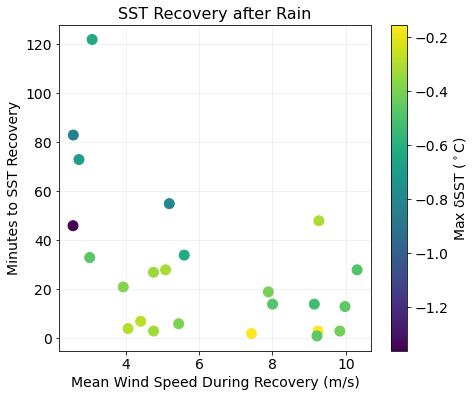

In [133]:
panel_font = 14
title_font = 16

fig,axx = plt.subplots(figsize=(7,6))
h1 = axx.scatter(windmeans,sst_recoveries,c=δssts,s=100)
cbar = plt.colorbar(h1,label='Max δSST ($^\circ$C)')

plt.xlabel('Mean Wind Speed During Recovery (m/s)',fontsize=panel_font)
plt.ylabel('Minutes to SST Recovery',fontsize=panel_font)
axx.xaxis.set_tick_params(labelsize=panel_font)
axx.yaxis.set_tick_params(labelsize=panel_font)
cbar.ax.tick_params(labelsize=panel_font)
cbar.ax.yaxis.label.set_fontsize(panel_font)

plt.title('SST Recovery after Rain',fontsize=title_font)
axx.grid(alpha=0.2)

#plt.savefig('./Figures/Wind Speed vs. Time for SST to Recover after Rain v2.png', dpi=300)

# Combine these two figures into 1 with 2 panels

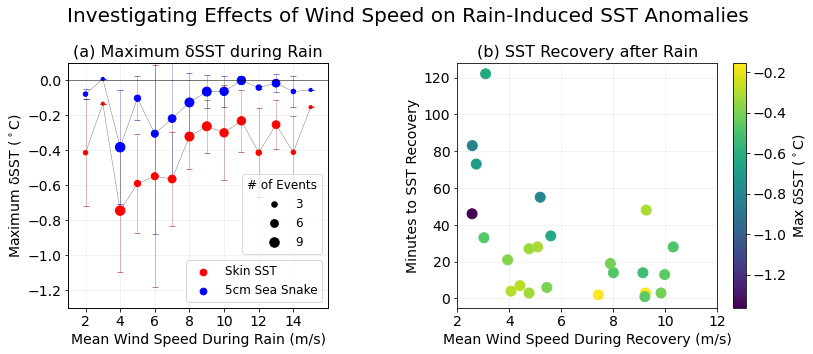

In [134]:
panel_font = 14
title_font = 16
capsz = 3

fig = plt.figure(figsize=(11.5,5))
axx0 = plt.subplot2grid(shape=(5,12),loc=(0,0),rowspan=5,colspan=5)

#---Figure 1: Max SST deviation as a funtion of wind speed---
axx0.errorbar(x=wind_bins, y=δsst_means, yerr=δsst_stds, fmt='-k', ecolor='darkred', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h1 = axx0.scatter(x=wind_bins, y=δsst_means, s=sizes, c='red',zorder=200)

axx0.errorbar(x=wind_bins, y=δTsea_means, yerr=δTsea_stds, fmt='-k', ecolor='darkblue', linewidth=0.5, capsize=capsz, zorder=100, alpha = 0.5)
h2 = axx0.scatter(x=wind_bins, y=δTsea_means, s=sizes, c='blue',zorder=200)

axx0.hlines(y=0,xmin=0,xmax=17,color='k',linewidth = 0.5,zorder=1000)

axx0.legend([h1,h2],['Skin SST','5cm Sea Snake'])

par = axx0.twinx()
par.legend(handles = h2.legend_elements("sizes", num=3)[0], labels=['3','6','9'], title='# of Events', bbox_to_anchor=(1,0.57), framealpha=0.7).set_zorder(1000)
par.set_yticks([])

axx0.set_title('(a) Maximum δSST during Rain', fontsize=title_font)

axx0.set_xlim([1,16])
axx0.set_ylim([-1.3,0.1])

axx0.set_xlabel('Mean Wind Speed During Rain (m/s)', fontsize=panel_font)
axx0.set_ylabel('Maximum δSST ($^\circ$C)', fontsize=panel_font)
axx0.xaxis.set_tick_params(labelsize=panel_font)
axx0.yaxis.set_tick_params(labelsize=panel_font)

axx0.set_xticks([2,4,6,8,10,12,14])
axx0.grid(alpha=0.2)

#-----Figure 2: Recovery as a function of wind speed----
axx1 = plt.subplot2grid(shape=(5,12),loc=(0,6),rowspan=5,colspan=6)

h1 = axx1.scatter(windmeans,sst_recoveries,c=δssts,s=100)
cbar = plt.colorbar(h1,ax=axx1,label='Max δSST ($^\circ$C)')

axx1.set_xlabel('Mean Wind Speed During Recovery (m/s)',fontsize=panel_font)
axx1.set_ylabel('Minutes to SST Recovery',fontsize=panel_font)
axx1.xaxis.set_tick_params(labelsize=panel_font)
axx1.yaxis.set_tick_params(labelsize=panel_font)
cbar.ax.tick_params(labelsize=panel_font)
cbar.ax.yaxis.label.set_fontsize(panel_font)
axx1.set_xticks([2,4,6,8,10,12])

axx1.set_title('(b) SST Recovery after Rain',fontsize=title_font)
axx1.grid(alpha=0.2)

plt.suptitle('Investigating Effects of Wind Speed on Rain-Induced SST Anomalies',fontsize=20,y=0.98)

plt.tight_layout()

plt.savefig('../Publication/JGR Submission 1/Figures/Figure_7.png', dpi=300)

# Supplementary Material

### Raindrop Obstruction of the Radiometer Optical Path

For our KT15.82 Detector Type A Lens K6

In [44]:
R = 20 #[mm/hr] rain rate

h = 5 #[m], vertical freeboard of radiometer (currently guessing)
θ = 30 #[degrees], angle from vertical of radiometer
l = h/np.cos(np.deg2rad(θ))
l*1000

5773.502691896258

In [92]:
#read spot diameter off of KT15 chart for that distance
D = 150 #mm, should end up somewhere between 100 and 200 mm depending on which detector type we have and the exact freeboard
#calculate volume of observation cone
A = np.pi*(D/1000/2)**2 # [m^2] area of cone base (convert mm->m and diameter->radius)
V = (l/3)*A #[m^3] volume of cone

#Raindrop size distribution based on rain rate
R = 25 #[mm/hr] rain rate
r = np.linspace(0.0005, 0.0025, num=100) #[m] #vector of possible drop radii from 1mm to 5mm
Λ = -41*100*(R**-0.21) #[1/m]
n = (0.08*1e8)*np.exp(Λ*r*2) #[m-3 m-1] number of drops in the volume at a certain radius (*2 because originally formulated in terms of diameter)

#DSD -> obscured area
area_per_r = np.pi*(r**2)*V*n
total_area = np.trapz(area_per_r, r)

total_area/A

0.0008686168599839131

In [95]:
def obscured_area(R, l, D):
    '''
    Calculate percentage of radiometer spot area obscured by raindrops in the optical path. 
    Naive calculation assuming no raindrops are behind one another, ie every single drop is blocking additional photons. Thus gives a high bound for the amount of blocked area possible. 
    
    Inputs:
        R - [mm/hr] rain rate
        l - [m] path length between radiometer lens and target
        D - [m] diameter of radiometer spot at this path length
        
    Outputs:
        O - Ratio between obscured area and total area
    '''
    #calculate volume of observation cone
    A = np.pi*(D/2)**2 # [m^2] area of cone base (convert diameter->radius)
    V = (l/3)*A #[m^3] volume of cone

    #Raindrop size distribution based on rain rate
    r = np.linspace(0, 0.005, num=200) #[m] #vector of possible drop radii up to 5mm
    Λ = -41*100*(R**-0.21) #[1/m]
    n = (0.08*1e8)*np.exp(Λ*r*2) #[m-3 m-1] number of drops in the volume at a given radius (*2 because originally formulated in terms of diameter)

    #convert size distribution -> obscured area
    area_per_r = np.pi*(r**2)*V*n #[m^2 m-1] obscured area at a given radius
    rain_area = np.trapz(area_per_r, r) #total obscured area integrated across all radii

    return rain_area/A

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


Text(0.5, 1.0, 'Obscuring of Radiometer Spot Area by Falling Raindrops')

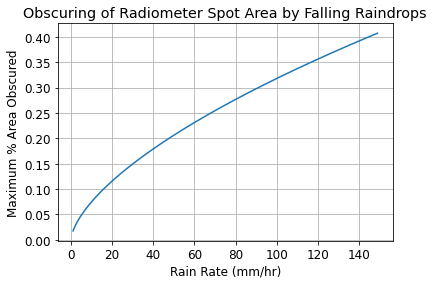

In [103]:
h = 5 #[m], vertical freeboard of radiometer (approximate)
θ = 30 #[degrees], angle from vertical of radiometer (approximate)
l = h/np.cos(np.deg2rad(θ))
#read spot diameter off of KT15 chart for that distance
D = 0.150 #[m], should end up somewhere between 100 and 200 mm depending on which detector type we have and the exact freeboard

rains = np.arange(0,150)
ratios = []

for R in rains:
    ratios.append(obscured_area(R, l, D)*100)
    
plt.plot(rains, ratios)
plt.ylabel('Maximum % Area Obscured')
plt.xlabel('Rain Rate (mm/hr)')
plt.grid()
plt.title('Obscuring of Radiometer Spot Area by Falling Raindrops')

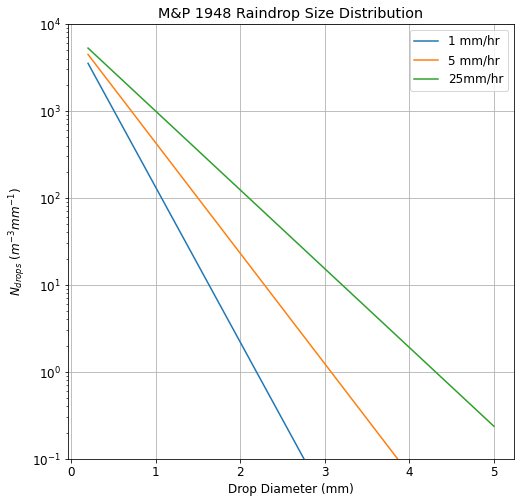

In [89]:
#RECREATING M&P 48 FIGURE 2 FOR COMPLETENESS
D = 150 #mm, should end up somewhere between 100 and 200 mm depending on which detector type we have and the exact freeboard
#Raindrop size distribution based on rain rate
R = 25 #[mm/hr] rain rate
r = np.linspace(0.0001, 0.0025, num=100) #[m] #vector of possible drop radii from 1mm to 5mm

plt.figure(figsize=(8,8))

for R in [1,5,25]:
    Λ = -41*100*(R**-0.21) #[1/m]
    n = (0.08*1e5)*np.exp(Λ*r*2) #drop size distribution with radius (*2 because originally formulated in terms of diameter)
    plt.semilogy(r*2*1000, n)

plt.legend(['1 mm/hr','5 mm/hr', '25mm/hr'])
plt.title('M&P 1948 Raindrop Size Distribution')
plt.xlabel('Drop Diameter (mm)')
plt.ylabel('$N_{drops}$ $(m^{-3} mm^{-1})$')
plt.ylim([10**-1, 10**4])
plt.grid()

This is a nice replication of Figure 2 from Marshall & Palmer 1948.

# Event Selection Criteria

Our definition of an event must be informed first and foremost by the goal of the study, along with the limitations of our measurements. Our goal in this study is to use a months-long dataset of high-accuracy radiometric skin temperature measurements to test our quantitative understanding of the local response of SST to rainfall. Because advection plays a major role in the spatial structure of surface freshwater pools, and our measurements were made from a stationary Eulerian frame (the ship was always holding station directed westward into the ~0.8m/s eastward-flowing surface current), we concentrate specifically on the time frame from immediately before local onset of rainfall until the maximum rain rate is reached. Ultimately, knowledge of the spatial structure of the surface ocean surrounding the measurement site will always be a relevant factor in predicting the time-evolution of local SST - even without the presence of rain. 

Where appropriate, we maintain rain event parameters analogous to those used by Thompson et al., 2019 so that these complementary DYNAMO studies can be interpreted together. 

#### 1. Noise Floor
We establish a noise floor for rain rate measurements of 0.5 mm/hr based on the limitations of the precipitation sensor, consistent with previous studies (e.g. Weller et al., 2004). This is also the lowest non-zero rain rate reported by Thompson et al 2019. There are two orders of magnitude more measurements below the noise floor than in any other 0.5mm/hr bin, providing strong justification for this choice:

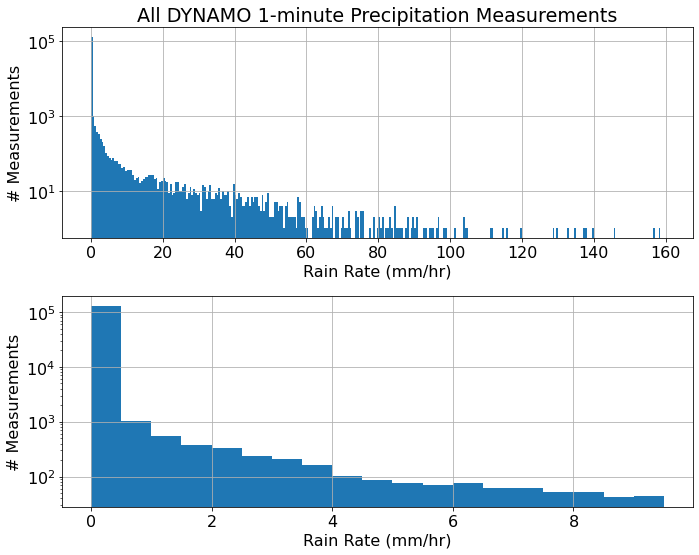

In [55]:
fig,axx = plt.subplots(nrows=2, facecolor='w',figsize=(10,8))

axx[0].hist(rv.P,bins=np.linspace(0,159.5,160*2),log=True)

axx[0].set_title('All DYNAMO 1-minute Precipitation Measurements')
axx[0].set_xlabel('Rain Rate (mm/hr)')
axx[0].set_ylabel('# Measurements')
axx[0].grid()
#axx[0].set_xlim([0,10])

axx[1].hist(rv.P,bins=np.linspace(0,9.5,20),log=True)
axx[1].set_xlabel('Rain Rate (mm/hr)')
axx[1].set_ylabel('# Measurements')
axx[1].grid()


plt.tight_layout()


#### 2. Minimum Duration: 
We set the minimum duration of an event to 10 minutes for consistency with Thompson et al., 2019. There were 27 events detected with durations shorter than 10 minutes; these short events (see figure) do not display clear trends in Skin SST, so we find their exclusion to be justified for our goals. Also, in order for the incorporation of rain heat flux into the COARE surface renewal model to be even remotely physically realistic, we must focus on rain events with high enough rain rates that it is reasonable to assume the surface layer consists largely of rainwater?

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


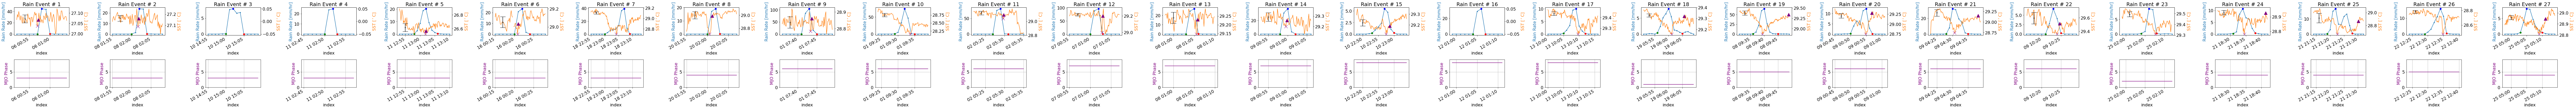

In [45]:
%autoreload
from RainEvent_Toolbox import find_rain_events

rain_event_list_30_min5_noduration = find_rain_events(dataset = rv, 
                                                      min_duration = 1,
                                                      min_separation = 30,
                                                      threshold = 5,
                                                      noise_floor = 0.5,
                                                      front_pad = 5, 
                                                       end_pad = 5)

short_events = []
for event_num in np.arange(0,len(rain_event_list_30_min5_noduration)):
    len_minutes = (rain_event_list_30_min5_noduration[event_num].attrs['Rain End'] - rain_event_list_30_min5_noduration[event_num].attrs['Rain Onset']).item()/1e9/60
    if len_minutes < 10:
        short_events.append(rain_event_list_30_min5_noduration[event_num])
        
from RainEvent_Toolbox import sst_rain_response
sst_event_list = sst_rain_response(rain_event_list = short_events,
                                   sst = kt_1m,
                                   pre_onset_averaging = pre_onset_averaging)
plt.savefig('./Figures/Dynamo SHORT Events + MJO Phase v1.png')

#### 3. Minimum Inter-Event Time
Thompson et al., 2019 require 30 minutes of zero rainfall in order for futher rainfall to be considered a new event. While multiple precipitation fronts can be part of the same convective system, if they are separated by long periods of near-zero rainfall, then it may be most appropriate for our algorithm to treat them as separate events. 

#### 4. Peak rain rate threshold
Events need to involve enough rain for our heat flux calculations to be reasonably robust.

We can map out how sensitive the number of detected events is to changes in these two criteria:

In [ ]:
%autoreload
from RainEvent_Toolbox import find_rain_events

separations = np.arange(5,60,5)
thresholds = np.arange(0,12,1)

events = np.empty(shape=(len(separations),len(thresholds)))

for sep_idx in tqdm.tqdm(np.arange(0,len(separations))):
    for thresh_idx in tqdm.tqdm(np.arange(0,len(thresholds))):
        event_list = find_rain_events(dataset = rv, 
                                      min_duration = 10,
                                      min_separation = separations[sep_idx],
                                      threshold = thresholds[thresh_idx],
                                      noise_floor = 0.5,
                                      front_pad = 5, 
                                      end_pad = 5)
        events[sep_idx,thresh_idx] = len(event_list)
        plt.close()

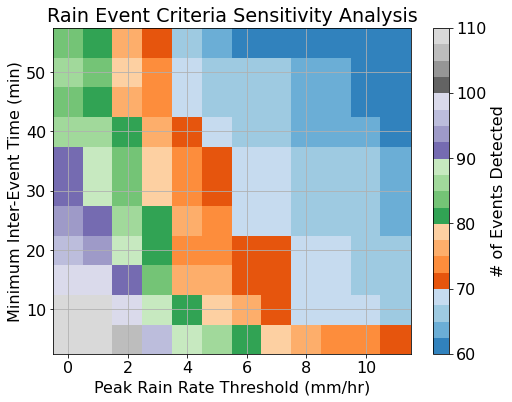

In [33]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(8,6))
plt.pcolormesh(thresholds,separations,events,shading='auto',cmap='tab20c',vmin=60,vmax=110)
plt.colorbar(label='# of Events Detected')
plt.xlabel('Peak Rain Rate Threshold (mm/hr)',fontsize=16)
plt.ylabel('Minimum Inter-Event Time (min)',fontsize=16)
plt.grid()

plt.title('Rain Event Criteria Sensitivity Analysis')

plt.savefig('./Figures/Rain Event Criteria Sensitivity Analysis v1.png')

10 mm/hr seems a very reasonable peak rain rate threshold for translating rain rates into heat flux robustly. Given this threshold selection, varying the minimum inter-event time between 10 and 30 minutes only changes the number of detected events by 3 (68 events for 10 minutes, 65 events for 30 minutes). Our focus on the local near-instantaneous response of skin SST to rain would seem to justify a shorter inter-event interval - even if the effects of rain are still present in the surface ocean right before the onset of another event, we are only looking at the deviation from the pre-onset mean. This reinforces the need to minimize the averaging interval that defines the pre-onset mean. 

#### 5. Sensitivity of inter-event distributions to specified noise floor
Running the analysis with no noise floor produces 69 events (vs 68 with the 0.5mm/hr floor). The main effect of removing the noise floor is that we get the same events but some now have very long tails and heads of occasional >0 but <0.5mm/hr measurements. This serves only to introduce unwarranted confusion to the goals of the study. We can see that removing the noise floor leads to more very short inter-event intervals, but mostly the same distribution:


In [6]:
#plot events with no noise floor
rain_event_list_nofloor = find_rain_events(dataset = rv, 
                                           min_duration = 10,
                                           min_separation = 30,
                                           threshold = 5,
                                           noise_floor = 0,
                                           front_pad = 5, 
                                           end_pad = 5)

len(rain_event_list_nofloor)

#from RainEvent_Toolbox import sst_rain_response
#sst_event_list = sst_rain_response(rain_event_list = rain_event_list_nofloor,
#                                   sst = kt_1m,
#                                   pre_onset_averaging = pre_onset_averaging)

74

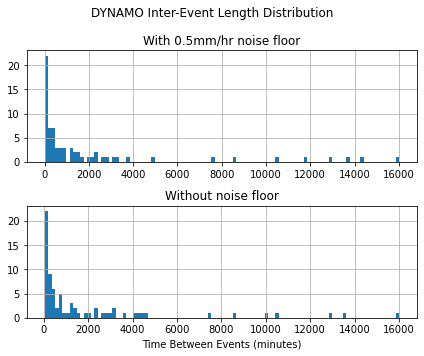

In [10]:
#calculate distribution of inter-event intervals for the two cases
rain_times = []
for event_num in np.arange(0,len(rain_event_list)-1):
    len_minutes = (rain_event_list[event_num+1].attrs['Rain Onset'] - rain_event_list[event_num].attrs['Rain End']).item()/1e9/60
    rain_times.append(len_minutes)
    
rain_times_nofloor = []
for event_num in np.arange(0,len(rain_event_list_nofloor)-1):
    len_minutes = (rain_event_list_nofloor[event_num+1].attrs['Rain Onset'] - rain_event_list_nofloor[event_num].attrs['Rain End']).item()/1e9/60
    rain_times_nofloor.append(len_minutes)
    
fig,axx = plt.subplots(facecolor='w',figsize=(6,5),nrows=2)
axx[0].hist(rain_times,bins=100);
axx[1].hist(rain_times_nofloor, bins=100)

plt.suptitle('DYNAMO Inter-Event Length Distribution')
axx[0].set_title('With 0.5mm/hr noise floor')
axx[1].set_title('Without noise floor')

axx[1].set_xlabel('Time Between Events (minutes)')

axx[0].grid()
axx[1].grid()

plt.tight_layout()

plt.savefig('./Figures/InterEvent Histograms v2.png',dpi=300)